<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_09/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Augmentation**

### Como base foi utilizado o trabalho dos Profs. Storopoli & Souza disponível no Google Colab:
https://colab.research.google.com/github/storopoli/ciencia-de-dados/blob/main/notebooks/Aula_19_Redes_Neurais_Convolucionais_com_PyTorch.ipynb#scrollTo=oR24U2WYKVrw


Importando bibliotecas necessárias:

In [18]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader,random_split
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import time

Device: usa GPU se disponível

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Treinando em:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Treinando em: cuda
GPU: Tesla T4


### **Exercício 1 - modificando a transformação.**

In [20]:
# com data augmentation
trans_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### **Exercício 2 - trans_aumentado**

In [21]:
trans_aumentado = transforms.Compose([
    transforms.RandomAffine(
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1),
    ),
    transforms.RandomPerspective(
        distortion_scale=0.2,
        p=0.5
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

### **Exercício 4 - pipelines**

Baseline - apenas normalização

In [22]:
trans_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Básico - RandomAffine (rotação + translação)

In [23]:
trans_basico = transforms.Compose([
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),
    ),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Avançado - TrivialAugmentWide + RandomErasing

In [24]:
trans_avancado = transforms.Compose([
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1))
])

Tranformação para teste

In [25]:
# sem data augmentation
trans_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

O modelo

In [26]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(7 * 7 * 64, 1000),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

Criando função de treinamento para os pipelines

In [27]:
def train_model(pipeline, trans_train):
    print(f"Treinando a pipeline: {pipeline}")

    # carregando os dados
    root_path = '/home/storopoli/Downloads'
    train_dataset_full = torchvision.datasets.MNIST(
        root=root_path, train=True, transform=trans_train, download=True
    )
    test_dataset = torchvision.datasets.MNIST(
        root=root_path, train=False, transform=trans_test
    )

    train_size = int(0.8 * len(train_dataset_full))
    val_size = len(train_dataset_full) - train_size
    train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])

    batch_size = 32
    num_workers = 0
    pin_memory = True if device.type == "cuda" else False

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                            num_workers=num_workers, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                             num_workers=num_workers, pin_memory=pin_memory)
    # criando o modelo
    model = ConvNet().to(device)
    parametros = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parâmetros treináveis: {parametros}")

    # hiperparâmetros
    loss_fn = nn.CrossEntropyLoss()
    learning_rate = 0.001
    epochs = 6
    optimizer = Adam(model.parameters(), lr=learning_rate)

    torch.backends.cudnn.benchmark = True if device.type == "cuda" else False

    # listas para histórico
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    start_time = time.time()

    # ========== LOOP DE TREINAMENTO ==========
    for epoch in range(epochs):
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            # forward + loss
            outputs = model(images)
            loss = loss_fn(outputs, labels)

            # backward + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # métricas do step
            total = labels.size(0)
            predicted = outputs.argmax(dim=1)
            correct = (predicted == labels).sum().item()
            acc = 100 * correct / total

            running_loss += loss.item()
            running_correct += correct
            running_total += total

        # calcular métricas
        train_epoch_loss = running_loss / len(train_loader)
        train_epoch_acc = 100 * running_correct / running_total

        train_losses.append(train_epoch_loss)
        train_accuracies.append(train_epoch_acc)

        # validação
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        print(f"Época [{epoch+1}/{epochs}] - "
              f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # teste final
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            predicted = outputs.argmax(dim=1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    training_time = time.time() - start_time

    print(f"Resultados da pipiline - {pipeline}")
    print(f"Acurácia no Teste: {test_accuracy:.3f}%")
    print(f"Melhor Acurácia na Validação: {best_val_acc:.2f}%")
    print(f"Tempo de Treinamento: {training_time:.2f}s")

    return {
        'name': pipeline,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'test_accuracy': test_accuracy,
        'best_val_acc': best_val_acc,
        'training_time': training_time
    }


Executando todos os pipilines

In [28]:
resultados = []

In [29]:
resultados.append(train_model("Ex 1- Apenas RandomRotation(15)", trans_train))

Treinando a pipeline: Ex 1- Apenas RandomRotation(15)
Parâmetros treináveis: 3199106
Época [1/6] - Train Loss: 0.1366, Train Acc: 95.88% | Val Loss: 0.0668, Val Acc: 97.89%
Época [2/6] - Train Loss: 0.0578, Train Acc: 98.20% | Val Loss: 0.0530, Val Acc: 98.44%
Época [3/6] - Train Loss: 0.0455, Train Acc: 98.55% | Val Loss: 0.0696, Val Acc: 97.91%
Época [4/6] - Train Loss: 0.0366, Train Acc: 98.90% | Val Loss: 0.0522, Val Acc: 98.63%
Época [5/6] - Train Loss: 0.0345, Train Acc: 98.96% | Val Loss: 0.0446, Val Acc: 98.78%
Época [6/6] - Train Loss: 0.0283, Train Acc: 99.12% | Val Loss: 0.0545, Val Acc: 98.60%
Resultados da pipiline - Ex 1- Apenas RandomRotation(15)
Acurácia no Teste: 99.330%
Melhor Acurácia na Validação: 98.78%
Tempo de Treinamento: 144.27s


In [30]:
resultados.append(train_model("Ex 2 - Usando RandomAffine e RandomPerspective", trans_aumentado))

Treinando a pipeline: Ex 2 - Usando RandomAffine e RandomPerspective
Parâmetros treináveis: 3199106
Época [1/6] - Train Loss: 0.1861, Train Acc: 94.16% | Val Loss: 0.0742, Val Acc: 97.86%
Época [2/6] - Train Loss: 0.0771, Train Acc: 97.58% | Val Loss: 0.0572, Val Acc: 98.22%
Época [3/6] - Train Loss: 0.0583, Train Acc: 98.23% | Val Loss: 0.0511, Val Acc: 98.38%
Época [4/6] - Train Loss: 0.0511, Train Acc: 98.46% | Val Loss: 0.0600, Val Acc: 98.29%
Época [5/6] - Train Loss: 0.0435, Train Acc: 98.69% | Val Loss: 0.0406, Val Acc: 98.80%
Época [6/6] - Train Loss: 0.0405, Train Acc: 98.72% | Val Loss: 0.0535, Val Acc: 98.56%
Resultados da pipiline - Ex 2 - Usando RandomAffine e RandomPerspective
Acurácia no Teste: 98.890%
Melhor Acurácia na Validação: 98.80%
Tempo de Treinamento: 251.05s


In [31]:
resultados.append(train_model("Ex 4 - Baseline (Sem Augmentation)", trans_baseline))

Treinando a pipeline: Ex 4 - Baseline (Sem Augmentation)
Parâmetros treináveis: 3199106
Época [1/6] - Train Loss: 0.1149, Train Acc: 96.46% | Val Loss: 0.0660, Val Acc: 98.03%
Época [2/6] - Train Loss: 0.0451, Train Acc: 98.61% | Val Loss: 0.0480, Val Acc: 98.52%
Época [3/6] - Train Loss: 0.0280, Train Acc: 99.10% | Val Loss: 0.0453, Val Acc: 98.87%
Época [4/6] - Train Loss: 0.0232, Train Acc: 99.27% | Val Loss: 0.0520, Val Acc: 98.59%
Época [5/6] - Train Loss: 0.0169, Train Acc: 99.49% | Val Loss: 0.0522, Val Acc: 98.66%
Época [6/6] - Train Loss: 0.0149, Train Acc: 99.54% | Val Loss: 0.0455, Val Acc: 98.98%
Resultados da pipiline - Ex 4 - Baseline (Sem Augmentation)
Acurácia no Teste: 98.870%
Melhor Acurácia na Validação: 98.98%
Tempo de Treinamento: 111.65s


In [32]:
resultados.append(train_model("Ex 4  - Básico (RandomAffine)", trans_basico))

Treinando a pipeline: Ex 4  - Básico (RandomAffine)
Parâmetros treináveis: 3199106
Época [1/6] - Train Loss: 0.2271, Train Acc: 92.71% | Val Loss: 0.1296, Val Acc: 95.94%
Época [2/6] - Train Loss: 0.0891, Train Acc: 97.24% | Val Loss: 0.0704, Val Acc: 97.92%
Época [3/6] - Train Loss: 0.0696, Train Acc: 97.86% | Val Loss: 0.0569, Val Acc: 98.19%
Época [4/6] - Train Loss: 0.0625, Train Acc: 98.04% | Val Loss: 0.0658, Val Acc: 97.97%
Época [5/6] - Train Loss: 0.0558, Train Acc: 98.21% | Val Loss: 0.0559, Val Acc: 98.22%
Época [6/6] - Train Loss: 0.0524, Train Acc: 98.41% | Val Loss: 0.0485, Val Acc: 98.35%
Resultados da pipiline - Ex 4  - Básico (RandomAffine)
Acurácia no Teste: 99.150%
Melhor Acurácia na Validação: 98.35%
Tempo de Treinamento: 151.89s


In [33]:
resultados.append(train_model("Ex 4 - Avançado (TrivialAugment + RandomErasing)", trans_avancado))

Treinando a pipeline: Ex 4 - Avançado (TrivialAugment + RandomErasing)
Parâmetros treináveis: 3199106
Época [1/6] - Train Loss: 0.5852, Train Acc: 80.50% | Val Loss: 0.4314, Val Acc: 85.34%
Época [2/6] - Train Loss: 0.3664, Train Acc: 87.39% | Val Loss: 0.3306, Val Acc: 88.88%
Época [3/6] - Train Loss: 0.3217, Train Acc: 88.84% | Val Loss: 0.3083, Val Acc: 89.19%
Época [4/6] - Train Loss: 0.3033, Train Acc: 89.54% | Val Loss: 0.2941, Val Acc: 89.92%
Época [5/6] - Train Loss: 0.2826, Train Acc: 90.16% | Val Loss: 0.2871, Val Acc: 90.17%
Época [6/6] - Train Loss: 0.2761, Train Acc: 90.44% | Val Loss: 0.2952, Val Acc: 89.92%
Resultados da pipiline - Ex 4 - Avançado (TrivialAugment + RandomErasing)
Acurácia no Teste: 99.110%
Melhor Acurácia na Validação: 90.17%
Tempo de Treinamento: 251.77s


Gráfico com todos os Loss:

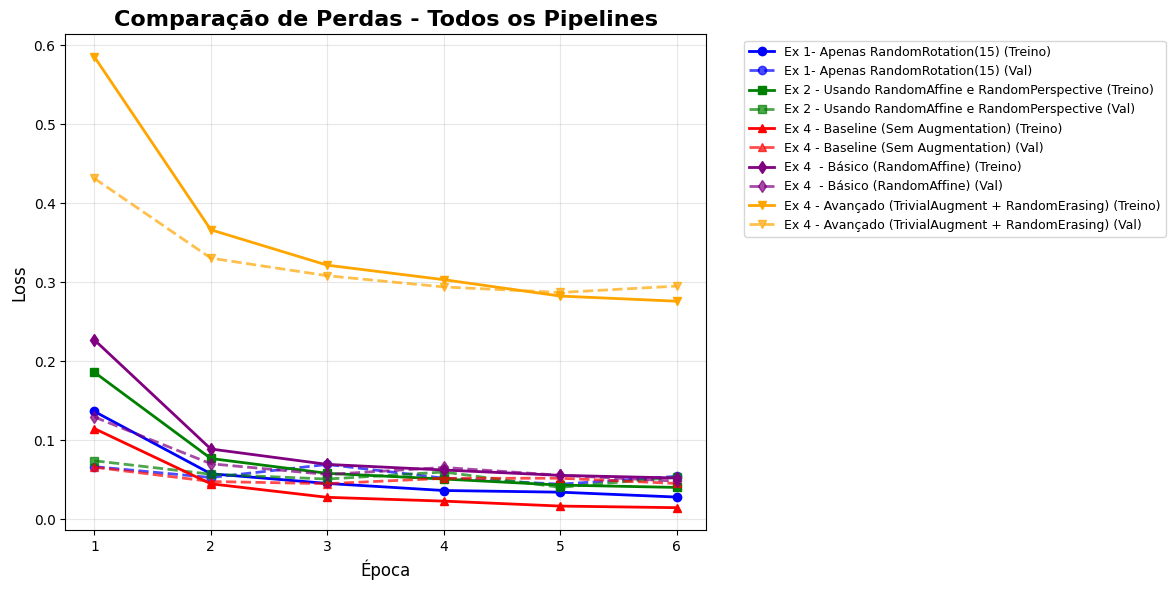

In [42]:
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']
markers = ['o', 's', '^', 'd', 'v', '<', '>', 'p']

plt.figure(figsize=(12, 6))
for i, result in enumerate(resultados):
    num_epochs = len(result['train_losses'])
    epochs_range = range(1, num_epochs + 1)

    # loss de treino (linha sólida)
    plt.plot(epochs_range, result['train_losses'],
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-',
             label=f"{result['name']} (Treino)", linewidth=2)
    # loss de validação (linha tracejada)
    plt.plot(epochs_range, result['val_losses'],
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='--',
             label=f"{result['name']} (Val)", linewidth=2, alpha=0.7)

plt.title('Comparação de Perdas - Todos os Pipelines', fontsize=16, fontweight='bold')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

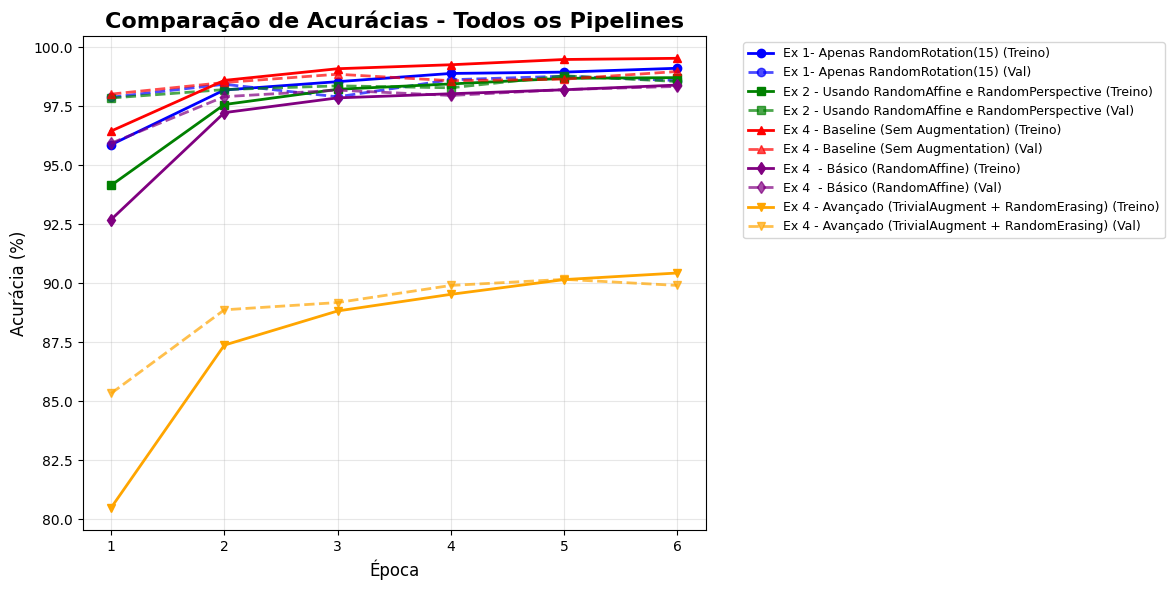

In [43]:
plt.figure(figsize=(12, 6))
for i, result in enumerate(resultados):
    num_epochs = len(result['train_accuracies'])
    epochs_range = range(1, num_epochs + 1)

    # acurácia de treino (linha sólida)
    plt.plot(epochs_range, result['train_accuracies'],
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='-',
             label=f"{result['name']} (Treino)", linewidth=2)
    # acurácia de validação (linha tracejada)
    plt.plot(epochs_range, result['val_accuracies'],
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='--',
             label=f"{result['name']} (Val)", linewidth=2, alpha=0.7)

plt.title('Comparação de Acurácias - Todos os Pipelines', fontsize=16, fontweight='bold')
plt.xlabel('Época', fontsize=12)
plt.ylabel('Acurácia (%)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Gráfico comparativo:

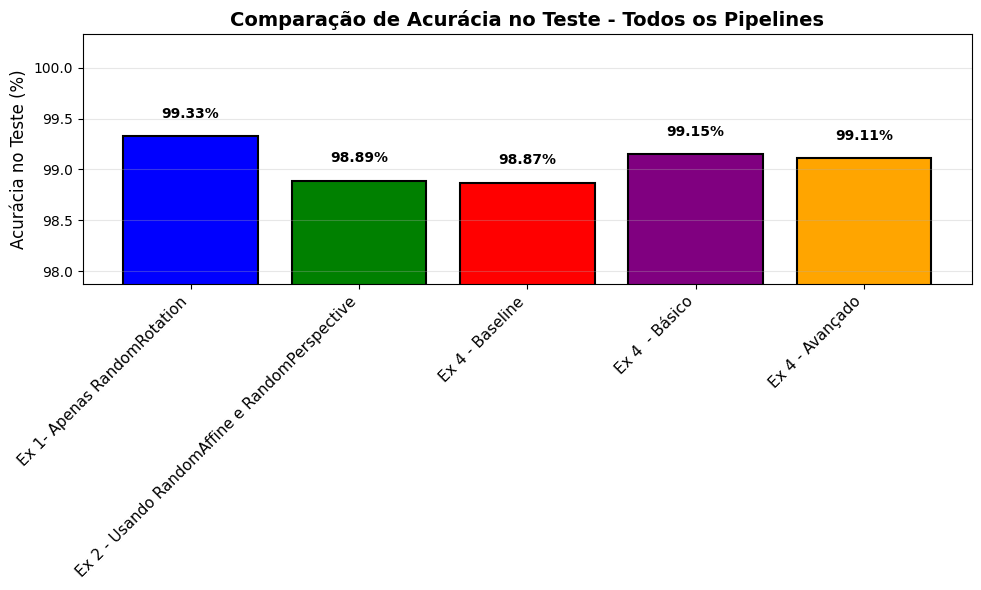

In [45]:
plt.figure(figsize=(10, 6))

pipeline_names = [r['name'] for r in resultados]
test_accs = [r['test_accuracy'] for r in resultados]

bars = plt.bar(range(len(resultados)), test_accs, color=colors, edgecolor='black', linewidth=1.5)
plt.xticks(range(len(resultados)), [name.split('(')[0].strip() for name in pipeline_names],
           rotation=45, ha='right', fontsize=11)
plt.ylabel('Acurácia no Teste (%)', fontsize=12)
plt.title('Comparação de Acurácia no Teste - Todos os Pipelines', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([min(test_accs) - 1, max(test_accs) + 1])

# adicionar valores nas barras
for i, v in enumerate(test_accs):
    plt.text(i, v + 0.15, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()